Some images are extremely similar but have completely different masks (one has mask the other not)

See https://www.kaggle.com/c/ultrasound-nerve-segmentation/forums/t/21495/is-the-training-data-accurate

This scripts tries to find such images

In [1]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set f

In [2]:
TRAIN_PATH = '../data/train'

In [39]:
def load_and_preprocess(imgname):
    img_fname = imgname
    mask_fname = os.path.splitext(imgname)[0] + "_mask.tif"
    img = cv2.imread(os.path.join(TRAIN_PATH, img_fname), cv2.IMREAD_GRAYSCALE)
    assert img is not None
    mask = cv2.imread(os.path.join(TRAIN_PATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    assert mask is not None
    
    #newsize = (img.shape[1] / 4, img.shape[0] / 4)
    #newsize = (128, 128)
    #img = cv2.resize(img, newsize)
    #mask = cv2.resize(mask, newsize)
    mask = (mask > 128).astype(np.float32)
    
    # TODO: Could subtract mean as on fimg above
    img = img.astype(np.float32) / 255.0
    np.ascontiguousarray(img)
    return img, mask


def load_patient(pid):
    fnames = [os.path.basename(fname) for fname in glob.glob(TRAIN_PATH + "/%d_*.tif" % pid) if 'mask' not in fname]
    imgs, masks = zip(*map(load_and_preprocess, fnames))
    imgs = np.array(imgs)
    masks = np.array(masks)
    return imgs, masks, fnames

In [40]:
imgs, masks, fnames = load_patient(6)

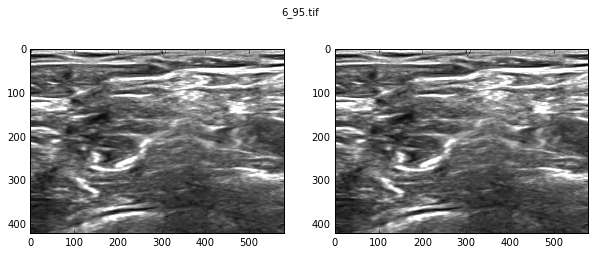

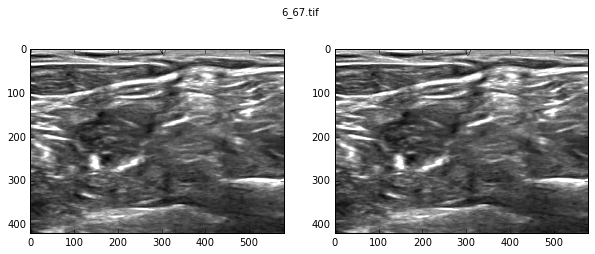

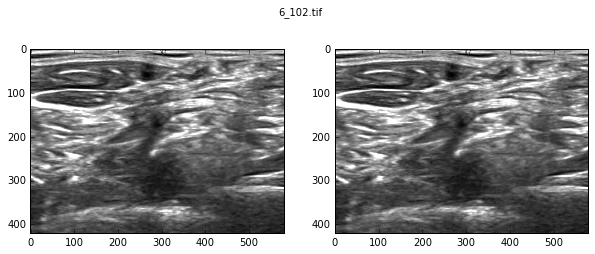

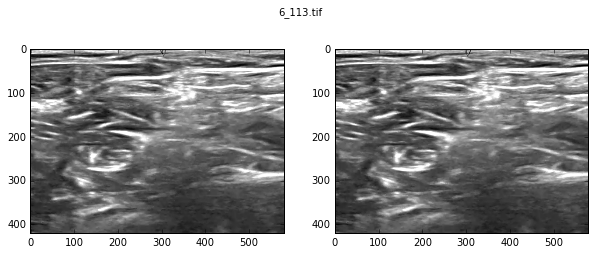

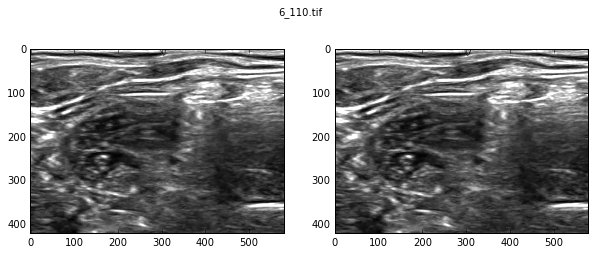

In [41]:
def show(i):
    pl.figure(figsize=(10, 4))
    pl.suptitle(fnames[i])
    pl.subplot(121)
    pl.imshow(imgs[i], cmap=cm.gray)
    
    pl.subplot(122)
    pl.imshow(imgs[i], cmap=cm.gray)
    h, w = imgs[i].shape[:2]
    overlay = np.zeros((h, w, 4), dtype=np.uint8)
    overlay[masks[i] > 0, :] = (200, 30, 30, 255)
    pl.imshow(overlay, alpha=1)
    
for i in range(5):
    show(i)

# Finding similar images with different masks

In [42]:
import skimage.util

def compute_img_hist(img):
    # Divide the image in blocks and compute per-block histogram
    blocks = skimage.util.view_as_blocks(img, block_shape=(20, 20))
    img_hists = [np.histogram(block, bins=np.linspace(0, 1, 10))[0] for block in blocks]
    return np.concatenate(img_hists)

img = imgs[0]
compute_img_hist(img)

array([ 370,  465,  727, 1103, 1901, 2782, 2103, 1046, 1103,  147,  571,
       2017, 1913, 1595, 1897, 1715,  714, 1031,  138, 1294, 2339, 2492,
       1511,  807,  483,  432, 2104,   32,  408, 2177, 2399, 1665, 1577,
       1112,  797, 1433,   21,  249, 2145, 2638, 2053, 1591, 1092,  638,
       1173,   48,  320, 1212, 2760, 2549, 1754, 1012,  675, 1270,   37,
        156, 1483, 2228, 2496, 2164, 1129,  634, 1273,  242,  482, 1986,
       3003, 2893, 1764,  542,  204,  484,  159,  824, 3031, 3464, 2148,
       1210,  480,  164,  120,   77, 1103, 3797, 3191, 1606,  871,  395,
        229,  331,   90, 1448, 3648, 2519, 1891, 1158,  457,  132,  257,
         56,  696, 3132, 4061, 1904, 1008,  565,  101,   77,   97,  305,
       3228, 4667, 1675,  683,  378,  164,  403,   41,  335, 3196, 4143,
       1805,  628,  338,  260,  854,   67,  973, 4182, 2401, 1535,  989,
        487,  360,  606,   41, 1514, 5251, 2491, 1168,  690,  180,   98,
        167,   47, 2055, 5349, 2839,  794,  225,  1

In [43]:
#hists = np.array([np.histogram(img, bins=np.linspace(0, 1, 20))[0] for img in imgs])
hists = np.array(map(compute_img_hist, imgs))
hists.shape

(120, 189)

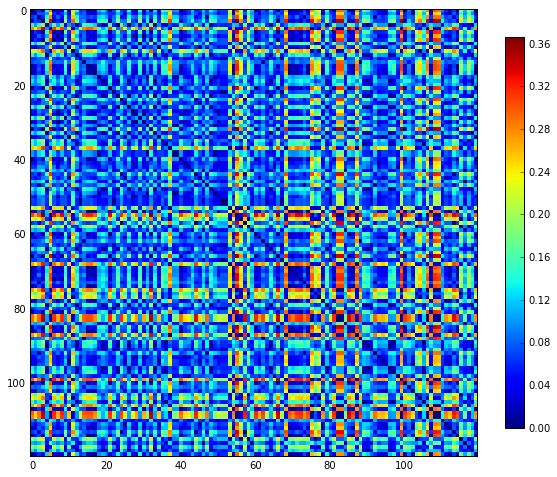

In [44]:
import scipy.spatial.distance as spdist

D = spdist.squareform(spdist.pdist(hists, metric='cosine'))

pl.figure(figsize=(10, 10))
pl.imshow(D, interpolation='nearest')
pl.colorbar(shrink=0.7)

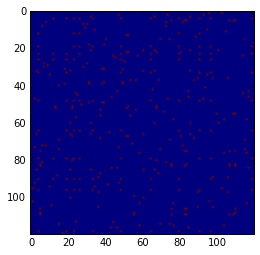

In [45]:
close_pairs = D + np.eye(D.shape[0]) < 0.008
pl.imshow(close_pairs)

In [46]:
close_ij = np.transpose(np.nonzero(close_pairs))
print close_ij.shape

(346, 2)


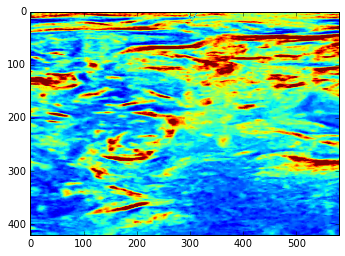

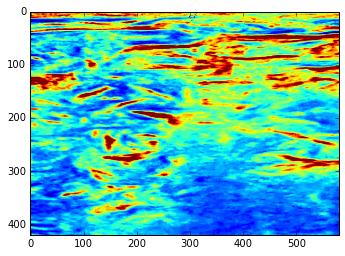

In [48]:
farthest = np.argmax(D[close_pairs])

pl.imshow(imgs[close_ij[farthest, 0]])
pl.figure()
pl.imshow(imgs[close_ij[farthest, 1]])

In [49]:
incoherent_ij = [(i, j) for i, j in close_ij if utils.dice_coefficient(masks[i], masks[j]) < 0.2]
incoherent_ij = np.array(incoherent_ij)
print incoherent_ij.shape

(72, 2)


0.0
D :  0.00555420788201


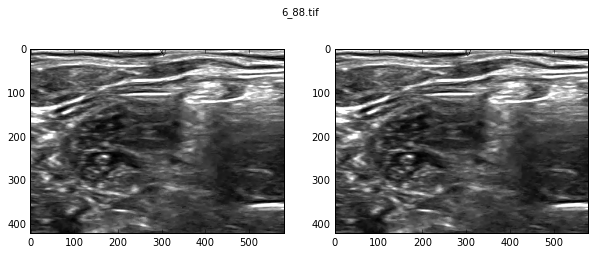

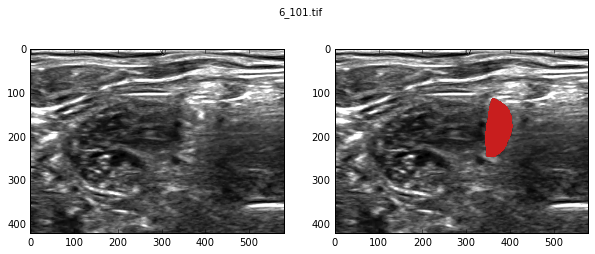

In [50]:
i, j = incoherent_ij[np.random.randint(incoherent_ij.shape[0])]

print utils.dice_coefficient(masks[i], masks[j])
print "D : ", D[i, j]
show(i)
show(j)

# Doing it on all images and creating a new "train_cleaned2" dataset where we copy the masks of nearest labelled image

In [14]:
import skimage
import skimage.io

In [118]:
def propagate_mask(imgs, masks):
    """
    Propagate mask between close images. We need to do that iteratively
    because if we have img1 <-> img2 and img2 <-> img3 with a mask for img1,
    but no mask for img2 and img3, we will propagate the mask of img1 to img2
    but will have created a new incoherent pair between the new img2 and img3
    """
    hists = np.array(map(compute_img_hist, imgs))
    D = spdist.squareform(spdist.pdist(hists, metric='cosine'))
    close_pairs = D + np.eye(D.shape[0]) < 0.008
    close_ij = np.transpose(np.nonzero(close_pairs))
    close_dists = D[close_ij[:,0], close_ij[:,1]]
    # order with closest first
    close_ij = close_ij[np.argsort(close_dists)]
    
    new_masks = masks.copy()
    
    print 'Propagating :',
    it = 0
    while True:
        print '|iter %d' % it,
        incoherent_ij = [
            (i, j) for i, j in close_ij \
            if utils.dice_coefficient(new_masks[i], new_masks[j]) < 0.2
        ]
        if len(incoherent_ij) == 0:
            break
        incoherent_ij = np.array(incoherent_ij)
        
        # It is possible that two close images have mask that have a dice coeff
        # of less than 0.2, in which case we do nothing. But we have to use a
        # stopping criterion to avoid infinite loops
        num_changed = 0
        for i, j in incoherent_ij:
            i_has_mask = np.sum(new_masks[i]) > 0
            j_has_mask = np.sum(new_masks[j]) > 0
            if not i_has_mask and j_has_mask:
                print ' %d->%d' % (i, j),
                new_masks[i] = new_masks[j]
                num_changed += 1
            elif i_has_mask and not j_has_mask:
                print ' %d->%d' % (i, j),
                new_masks[j] = new_masks[i]
                num_changed += 1
                
        if num_changed == 0:
            break
        it += 1
    print
    
    return new_masks

In [119]:
new_masks = propagate_mask(imgs, masks)

Propagating : |iter 0  96->48  51->52  95->102  118->19  90->96  118->64  6->8  94->34  4->96  42->65  51->13  33->118  25->45  96->23  72->81  44->113  96->79  51->22  1->95  50->27  71->54  24->44  67->51  26->96 |iter 1  26->12  67->80  57->24 |iter 2


In [122]:
OUTDIR = '../data/data_clean2'
if os.path.exists(OUTDIR):
    shutil.rmtree(OUTDIR)
utils.mkdir_p(OUTDIR)

def filter_images_for_patient(pid):
    imgs, masks, fnames = load_patient(pid)
    masks = propagate_mask(imgs, masks)

    for i in range(imgs.shape[0]):
        imgname = os.path.splitext(fnames[i])[0] + ".png"
        mask_fname = os.path.splitext(imgname)[0] + "_mask.png"
        img = skimage.img_as_ubyte(imgs[i])
        cv2.imwrite(os.path.join(OUTDIR, imgname), img)
        mask = skimage.img_as_ubyte(masks[i])
        cv2.imwrite(os.path.join(OUTDIR, mask_fname), mask)
    print 'Finished patient %d' % pid

#filter_images_for_patient(6)
for pid in range(1, 48):
    filter_images_for_patient(pid)

Propagating : |iter 0  26->87  25->106  95->100  10->8  98->39  33->26  69->65  119->67  72->19  66->118  58->52  88->77  83->108  84->10  100->94  97->118  115->100  41->72  10->111  76->3  49->3  59->10  42->100  109->98  30->40  10->91  56->72  67->6  46->112  23->30  110->10  28->10 |iter 1  6->79  109->64  43->109  88->4 |iter 2  4->86  14->4  22->4  4->54 |iter 3
Finished patient 1
Propagating : |iter 0  8->76  27->76  30->116  76->84  76->20  57->30 |iter 1  20->25  69->20  84->89  79->20  84->105  113->20  82->20  20->40  77->20 |iter 2  72->82  117->25 |iter 3
Finished patient 2
Propagating : |iter 0  22->88  102->29  26->1  67->29  75->17 |iter 1
Finished patient 3
Propagating : |iter 0  33->73  62->97  42->17  5->76  76->39  93->58  46->98  10->95  12->29  110->26  0->64  53->51 |iter 1
Finished patient 4
Propagating : |iter 0  117->116  117->62  76->113  94->60  19->110  46->99  113->112  38->110  51->68  50->61  20->68  68->49  99->77  37->82  26->37  104->68  68->34  72->